In [1]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
class Production_data:
    def __init__(self, number_of_periods, number_of_items, demand_forecast, production_cost, holding_cost, setup_cost, item_requirements , capacity):
        self.T=number_of_periods
        self.items=number_of_items
        self.demand_forecast=np.array(demand_forecast)
        self.production_cost=np.array(production_cost)
        self.holding_cost=np.array(holding_cost)
        self.setup_cost=np.array(setup_cost)
        self.item_requirements=np.array(item_requirements)
        self.capacity=np.array(capacity)

file_name = "CLSP+ST-instances Data-R.xlsx"
#file_name = "prova2.xlsx"

xls = pd.ExcelFile(file_name)  # Read the whole file

tables_keywords = ["Demand Forecast:", "Production Cost", "Holding Cost", "Setup Cost", "UnitsOfCapacity", "Capacity"]

In [3]:
def read_data(xls, sheet_name):
    tables_dict = {}
    df = pd.read_excel(xls, sheet_name=sheet_name)
    
    # Define which column to check for each keyword
    columns_to_check = {
        "Demand Forecast:": 0,
        "Production Cost": 0,
        "Holding Cost": 0,
        "Setup Cost": 0,
        "UnitsOfCapacity": 1,  # Check the second column for this keyword (it also contains setup time(i,2))
        "Capacity": 0
    }
    
    # Iterate through the keywords to find each table
    for keyword in tables_keywords:
        column_idx = columns_to_check.get(keyword, 0)
        
        # Check in the specified column for the keyword
        match = df[df.iloc[:, column_idx].astype(str).str.contains(keyword, na=False)]
        
        if not match.empty:
            table_start_row = match.index[0] + 1
            
            # Find the end of the current table (next keyword or empty rows)
            end_row = None
            for next_keyword in tables_keywords:
                if next_keyword != keyword:
                    next_column_idx = columns_to_check.get(next_keyword, 0)
                    next_match = df.loc[table_start_row:][df.loc[table_start_row:].iloc[:, next_column_idx].astype(str).str.contains(next_keyword, na=False)]
                    if not next_match.empty:
                        potential_end = next_match.index[0]
                        if end_row is None or potential_end < end_row:
                            end_row = potential_end
            
            # If no next keyword found, look for empty rows
            if end_row is None:
                for i in range(table_start_row, len(df)):
                    # Check if row is empty or contains only NaN values
                    if df.iloc[i].isna().all():
                        end_row = i
                        break
            
            # If still no end found, use the end of the dataframe
            if end_row is None:
                end_row = len(df)
            
            # Extract the table
            table_df = df.iloc[table_start_row:end_row]
            
            # Remove completely empty rows
            table_df = table_df.dropna(how='all')
            
            # Remove completely empty columns
            table_df = table_df.dropna(axis=1, how='all')
            
            # Remove any remaining NaN values by filling with 0
            table_df = table_df.fillna(0)
            
            # Convert to numpy array
            table = table_df.to_numpy()
            tables_dict[keyword] = table
    
    # Create an instance of Production_data class
    production_data = Production_data(
        tables_dict.get("Demand Forecast:", np.zeros((1,1))).shape[1]-1,
        tables_dict.get("Demand Forecast:", np.zeros((1,1))).shape[0]-1,  
        tables_dict.get("Demand Forecast:", np.zeros((1,1))),  
        tables_dict.get("Production Cost", np.zeros((1,1))),  
        tables_dict.get("Holding Cost", np.zeros((1,1))),  
        tables_dict.get("Setup Cost", np.zeros((1,1))),  
        tables_dict.get("UnitsOfCapacity", np.zeros((1,1))),  
        tables_dict.get("Capacity", np.zeros((1,1)))

    )
    
    production_data.capacity = np.vstack([
    np.zeros((1, production_data.capacity.shape[1]), dtype=production_data.capacity.dtype),production_data.capacity])

    production_data.item_requirements = np.vstack([
    np.zeros((1, production_data.item_requirements.shape[1]), dtype=production_data.item_requirements.dtype),production_data.item_requirements
])
    return production_data 

In [4]:
def solve_PLRF(data, sheet_name, results_df):

    model=gp.Model("PLRF")


    #decisions variables

    T=data.T
    O=data.items

    w=model.addVars(O+1, T+1, T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name = "w" )#fraction of demand of item i produced in period s to satisfy period t
    y=model.addVars(O+1, T+1, vtype=GRB.BINARY, name="y") #produce or not for item i in period i

    model.setObjective(
        #setup cost
        quicksum(quicksum( data.setup_cost[i, t] * y[i, t] for i in range(1, O+1) ) for t in range(1, T+1))+
        #production cost, j is actual period and t in future period
        quicksum(quicksum(quicksum(data.production_cost[i, s] * data.demand_forecast[i,t] * w[i, s, t] 
                          for t in range(s, T+1)) # Changed range
                 for s in range(1, T+1))
        for i in range(1, O+1))+
        #holding cost, i per item
        quicksum( quicksum(quicksum
                           (sum(data.holding_cost[ i, t] for t in range(s, j)) * data.demand_forecast[i, j] * w[i, s, j] for j in range(s+1, T+1))
                           for s in range(1, T+1)) for i in range(1, O+1)),
        GRB.MINIMIZE
    )
    
    

    
    # Each demand must be fully satisfied (like each customer must be served) for each item
    for i in range(1, O+1):
        for t in range(1, T+1):
            model.addConstr( quicksum(w[i, s, t] for s in range(1, t+1)) == 1, name= f"demand_{i}{t}")
            
    #cannot produce any fraction of demand in period s is the variable y is 0, for item i
    for i in range(1, O+1):
        for t in range(1, T+1):
            for s in range(1, t+1):
                model.addConstr( w[i, s, t] <= y[i, s] )
        
    #still capacity constraints fossure
    #constraint 3

    for s in range(1, T+1):
        model.addConstr(
            quicksum(
                # Production time: sum over all demands being produced in period s
                sum(w[i, s, t] * data.demand_forecast[i, t] for t in range(s, T+1)) * data.item_requirements[i, 1] +
                # Setup time
                data.item_requirements[i, 2] * y[i, s]
                for i in range(1, O+1)
            ) <= data.capacity[s, 1],
            name=f"capacity_{s}"
        )
        
    
    #constraint 4
    for t in range(1, T+1):
        for i in range(1, O+1):
            model.addConstr( sum( w[i, t, s] for s in range(t, T+1) )-(quicksum(data.demand_forecast[i, q] for q in range(t, T+1))) * y[i, t]<=0)

    
    #solve
    model.setParam('TimeLimit', 20*60)
    model.optimize()

    if model.status == GRB.OPTIMAL:

        print("\noptimal solution found:")

        # Create a list to store all periods' results for this sheet
        period_results = []
        
        # Collect results for each period
        for t in range(1, T+1):
            period_results.append({
                "Sheet": sheet_name,
                "Period": t,
                "Setup Decision": y[1, t].X,
                "Production Quantity": sum(w[2, t, j].X * data.demand_forecast[2, j] for j in range(t, T+1)),
                "Capacity Usage": sum(sum(w[i, t, j].X * data.demand_forecast[i, j] * data.item_requirements[i, 1] + data.item_requirements[i, 2] * y[i,t].X  
                                        for j in range(t, T+1)) 
                                    for i in range(1, O+1)) / data.capacity[t, 1],
                "Total Cost": model.objVal
            })
        
        sheet_results = pd.DataFrame(period_results)
        results_df = pd.concat([ results_df, sheet_results ], ignore_index=False)


    return results_df, model.ObjVal

In [5]:
results_df = pd.DataFrame(columns=["Sheet", "Period", "Inventory of item 1", "Produced for item 1"])
sheet_list=["Data-20-12 (1)", "Data-20-12 (2)", "Data-20-24 (1)", "Data-20-24 (2)" , "Data-100-24 (1)", "Data-100-24 (2)",
            "Data-200-24" ]

ObjVals = []

for sheet_name in sheet_list:
    break
    print(sheet_name)
    data = read_data(xls, sheet_name=sheet_name)
    
    start = time.time()
    results_df, Z = solve_PLRF(data, sheet_name, results_df)
    end = time.time()
    ObjVals.append((Z, end-start))



In [6]:
print(results_df)

Empty DataFrame
Columns: [Sheet, Period, Inventory of item 1, Produced for item 1]
Index: []


In [7]:
print(ObjVals)

[]


In [8]:
def Lagrangian_Relaxation_PLRF(data, optimal_value):
    model = gp.Model("PLRF_LR")

    T = data.T
    O = data.items

    # Initialize Lagrange multipliers
    mu = np.ones(T + 1)  # +1 because periods start from 1
    dual_bounds = []
    best_dual_bound = float('-inf')
    
    iteration = 0
    max_iterations = 1000
    tolerance = 0.05
    
    start = time.time()
    end = time.time()
    while iteration <= max_iterations and end-start <= 10*60:
        iteration += 1
        print(f'Iteration: {iteration}')
        
        # Decision variables
        w = model.addVars(O+1, T+1, T+1, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="w")
        y = model.addVars(O+1, T+1, vtype=GRB.BINARY, name="y")
        
        # Objective function with relaxed capacity constraints
        model.setObjective(
            # Setup cost
            quicksum(quicksum(data.setup_cost[i, t] * y[i, t] for i in range(1, O+1)) for t in range(1, T+1)) +
            # Production cost
            quicksum(quicksum(quicksum(data.production_cost[i, s] * data.demand_forecast[i,t] * w[i, s, t] 
                              for t in range(s, T+1))
                     for s in range(1, T+1))
            for i in range(1, O+1)) +
            # Holding cost
            quicksum(quicksum(quicksum(
                       sum(data.holding_cost[i, t] for t in range(s, j)) * data.demand_forecast[i, j] * w[i, s, j] 
                       for j in range(s+1, T+1))
                   for s in range(1, T+1)) for i in range(1, O+1)) +
            # Lagrangian term for relaxed capacity constraints
            quicksum(mu[s] * (
                quicksum(
                    sum(w[i, s, t] * data.demand_forecast[i, t] for t in range(s, T+1)) * data.item_requirements[i, 1] +
                    data.item_requirements[i, 2] * y[i, s]
                    for i in range(1, O+1)
                ) - data.capacity[s, 1]
            ) for s in range(1, T+1)),
            GRB.MINIMIZE
        )
        
        # Original constraints (excluding the relaxed capacity constraints)
        # Each demand must be fully satisfied
        for i in range(1, O+1):
            for t in range(1, T+1):
                model.addConstr(quicksum(w[i, s, t] for s in range(1, t+1)) == 1, name=f"demand_{i}{t}")
        
        # Production fraction constraint
        for i in range(1, O+1):
            for t in range(1, T+1):
                for s in range(1, t+1):
                    model.addConstr(w[i, s, t] <= y[i, s])
        
        # Additional constraint from original formulation
        for t in range(1, T+1):
            for i in range(1, O+1):
                model.addConstr(sum(w[i, t, s] for s in range(t, T+1)) - 
                               (quicksum(data.demand_forecast[i, q] for q in range(t, T+1))) * y[i, t] <= 0)
        
        model.optimize()
        end = time.time()

        if model.status == GRB.OPTIMAL:
            dual_obj = model.ObjVal
            dual_bounds.append(dual_obj)
            best_dual_bound = max(best_dual_bound, dual_obj)
            
            # Calculate subgradients for capacity constraints
            subgradient = np.zeros(T + 1)
            for s in range(1, T+1):
                subgradient[s] = sum(
                    sum(w[i, s, t].X * data.demand_forecast[i, t] for t in range(s, T+1)) * data.item_requirements[i, 1] +
                    data.item_requirements[i, 2] * y[i, s].X
                    for i in range(1, O+1)
                ) - data.capacity[s, 1]
            
            # Update Lagrange multipliers
            step_size = 1.0 / iteration  # Decreasing step size
            # mu = np.maximum(0, mu + step_size * subgradient)
            mu = np.maximum(0, mu + subgradient/np.max(np.abs(subgradient)*10))
            
            # Check for convergence
            if iteration > 25:
                recent_avg = np.mean(dual_bounds[-25:])
                if np.abs(recent_avg - best_dual_bound) / (best_dual_bound + 1e-6) < tolerance:
                    break
        else:
            print("Model not optimal in iteration", iteration)
            break
    
    gap = (optimal_value - best_dual_bound) / optimal_value if optimal_value != 0 else 0

    plt.figure(figsize=(10, 6))
    plt.plot(dual_bounds)
    plt.axhline(best_dual_bound, linestyle='--', color='red', linewidth=0.5, 
                label=f'Best Dual Bound: {best_dual_bound:.2f}')
    plt.axhline(optimal_value, linestyle='--', color='b', linewidth=0.5, 
                label=f'Optimal value: {optimal_value:.2f}')
    plt.title(f'Dual Bounds, Gap: {round(gap, 4)*100} %')
    plt.legend()
    plt.show()

    return best_dual_bound

In [9]:
results_LR = []
sheet_list=["Data-20-12 (1)", "Data-20-12 (2)", "Data-20-24 (1)", "Data-20-24 (2)" , "Data-100-24 (1)", "Data-100-24 (2)",
            "Data-200-24" ]

optimal_values = {'Data-20-12 (1)': 89469.0,
                  'Data-20-12 (2)': 14330786.370279722,
                  'Data-20-24 (1)': 5227122.577272725,
                  'Data-20-24 (2)': 6711666.365537237,
                  'Data-100-24 (1)': 37944696.08376624,
                  'Data-100-24 (2)': 37944696.08376624,
                  'Data-200-24': 75798079.88268259}

Data-20-12 (1)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-04
Iteration: 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2040 rows, 3822 columns and 6480 nonzeros
Model fingerprint: 0xff2dcad0
Variable types: 3549 continuous, 273 integer (273 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 84677.000000
Presolve removed 1965 rows and 3744 columns
Presolve time: 0.01s
Presolved: 75 rows, 78 columns, 197 nonzeros
Found heuristic solution: objective 47835.000000
Variable types: 23 continuous, 55 integer (55 binary)

Root relaxation: objective 4.754600e+04, 20 i

Presolve time: 0.03s
Presolved: 75 rows, 78 columns, 197 nonzeros
Variable types: 23 continuous, 55 integer (55 binary)

Root relaxation: interrupted, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      52290.8001 52288.1417  0.01%     -    0s

Explored 1 nodes (48 simplex iterations) in 0.08 seconds (0.06 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 52290.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.229080006291e+04, best bound 5.228814168369e+04, gap 0.0051%
Iteration: 7
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1428

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 24480 rows, 45864 columns and 77760 nonzeros
Model fingerprint: 0xc22fdb21
Variable types: 42588 continuous, 3276 integer (3276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 63079 (0.05s)
Loaded MIP start from previous solve with objective 63079

Presolve removed 24405 rows and 45786 columns
Presolve time: 0.05s
Presolved: 75 rows, 78 columns, 197 nonzeros
Variable types: 23 continuous, 55 integer (55 binary)

Root relaxation: interrupted, 44 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      63078.9697 63074.1506  0.01%     -   

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      68679.3051 68679.3051  0.00%     -    0s

Explored 1 nodes (19 simplex iterations) in 0.09 seconds (0.05 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 68679.3 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.867930512698e+04, best bound 6.867930512698e+04, gap 0.0000%
Iteration: 18
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 36720 rows, 68796 columns and 116640 nonzeros
Model fingerprint: 0x171f4a4c
Variable types: 63882 continuous, 4914 integer (4914 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [2e+01, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range

Model fingerprint: 0x8daeb64b
Variable types: 81627 continuous, 6279 integer (6279 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [7e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 76165.8 (0.05s)
Loaded MIP start from previous solve with objective 76165.8

Presolve removed 45180 rows and 86326 columns
Presolve time: 0.01s
Presolved: 1740 rows, 1580 columns, 5520 nonzeros
Variable types: 1360 continuous, 220 integer (220 binary)

Root relaxation: interrupted, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      76165.7796 76159.0617  0.01%     -    0s

Explored 1 nodes (20 simplex iterations) in 0.10 seconds (0.06 work units)
Thread count was 16 (of 16 available processors)

Sol


     0     0          -    0      80033.8457 80028.5179  0.01%     -    0s

Explored 1 nodes (38 simplex iterations) in 0.11 seconds (0.07 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 80033.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.003384574509e+04, best bound 8.002851793777e+04, gap 0.0067%
Iteration: 29
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 59160 rows, 110838 columns and 187920 nonzeros
Model fingerprint: 0xd2f64bc2
Variable types: 102921 continuous, 7917 integer (7917 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution wit

Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [4e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 82032.4 (0.05s)
Loaded MIP start from previous solve with objective 82032.4

Presolve removed 67620 rows and 128368 columns
Presolve time: 0.03s
Presolved: 1740 rows, 1580 columns, 5520 nonzeros
Variable types: 1360 continuous, 220 integer (220 binary)

Root relaxation: interrupted, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      82032.4445 82025.9484  0.01%     -    0s

Explored 1 nodes (35 simplex iterations) in 0.12 seconds (0.08 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 82032.4 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.2032


Explored 1 nodes (42 simplex iterations) in 0.13 seconds (0.09 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 84668.7 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.466874474033e+04, best bound 8.466874474033e+04, gap 0.0000%
Iteration: 40
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 81600 rows, 152880 columns and 259200 nonzeros
Model fingerprint: 0x3dd7630f
Variable types: 141960 continuous, 10920 integer (10920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [8e-01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 83779 (0.07s)
Loaded MIP start from previous solve with object

  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 85839.1 (0.07s)
Loaded MIP start from previous solve with objective 85839.1

Presolve removed 90060 rows and 170410 columns
Presolve time: 0.03s
Presolved: 1740 rows, 1580 columns, 5520 nonzeros
Variable types: 1360 continuous, 220 integer (220 binary)

Root relaxation: interrupted, 40 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      85839.0885 85833.7608  0.01%     -    0s

Explored 1 nodes (40 simplex iterations) in 0.15 seconds (0.10 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 85839.1 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.583908850059e+04, best bound

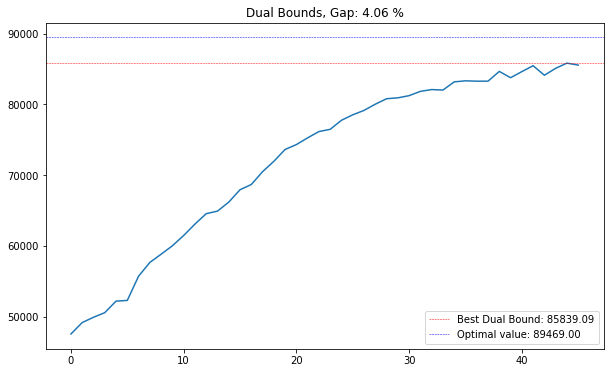

In [10]:
sheet_name = sheet_list[0]
print(sheet_name)
data = read_data(xls, sheet_name=sheet_name)

start = time.time()
Z = Lagrangian_Relaxation_PLRF(data, optimal_values[sheet_name])
end = time.time()

results_LR.append((Z, end-start))

Data-20-12 (2)
Iteration: 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2040 rows, 3822 columns and 6480 nonzeros
Model fingerprint: 0xa6eeef50
Variable types: 3549 continuous, 273 integer (273 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [6e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.933180e+07
Presolve removed 2040 rows and 3822 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 7.48156e+06 1.93318e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.481564000000e+06,


CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 16320 rows, 30576 columns and 51840 nonzeros
Model fingerprint: 0xfa5be480
Variable types: 28392 continuous, 2184 integer (2184 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [6e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 8.73365e+06 (0.02s)
Loaded MIP start from previous solve with objective 8.73365e+06

Presolve removed 16320 rows and 30576 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.05 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 8.73365e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.733653790533e+06, best bound 8.7


Optimal solution found (tolerance 1.00e-04)
Best objective 9.596273972282e+06, best bound 9.595579675328e+06, gap 0.0072%
Iteration: 15
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 30600 rows, 57330 columns and 97200 nonzeros
Model fingerprint: 0xb68ae557
Variable types: 53235 continuous, 4095 integer (4095 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [6e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 9.70947e+06 (0.03s)
Loaded MIP start from previous solve with objective 9.70947e+06

Presolve removed 29320 rows and 56170 columns
Presolve time: 0.01s
Presolved: 1280 rows, 1160 columns, 3825 nonzeros
Variable types: 94

  Matrix range     [1e+00, 1e+05]
  Objective range  [6e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 1.03564e+07 (0.03s)
Loaded MIP start from previous solve with objective 1.03564e+07

Presolve removed 41443 rows and 78996 columns
Presolve time: 0.02s
Presolved: 1397 rows, 1266 columns, 4257 nonzeros
Variable types: 1046 continuous, 220 integer (220 binary)

Explored 1 nodes (0 simplex iterations) in 0.06 seconds (0.04 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 1.03564e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.035637269206e+07, best bound 1.035637269206e+07, gap 0.0000%
Iteration: 22
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up t

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 57120 rows, 107016 columns and 181440 nonzeros
Model fingerprint: 0xc5c0dfa3
Variable types: 99372 continuous, 7644 integer (7644 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [6e+01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 1.0773e+07 (0.03s)
Loaded MIP start from previous solve with objective 1.0773e+07

Presolve removed 55653 rows and 105685 columns
Presolve time: 0.02s
Presolved: 1467 rows, 1331 columns, 4516 nonzeros
Variable types: 1111 continuous, 220 integer (220 binary)

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.07 seconds (0.05 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 1.0773e+07 

Optimal solution found (tolerance 1.00e-04)
Be


MIP start from previous solve produced solution with objective 1.10123e+07 (0.04s)
Loaded MIP start from previous solve with objective 1.10123e+07

Presolve removed 67861 rows and 128587 columns
Presolve time: 0.02s
Presolved: 1499 rows, 1361 columns, 4637 nonzeros
Variable types: 1141 continuous, 220 integer (220 binary)

Root relaxation: interrupted, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      1.1012e+07 1.1012e+07  0.01%     -    0s

Explored 1 nodes (3 simplex iterations) in 0.08 seconds (0.06 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 1.10123e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.101231724743e+07, best bound 1.101166924743e+07, gap 0.0059%
Iteration: 35
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.

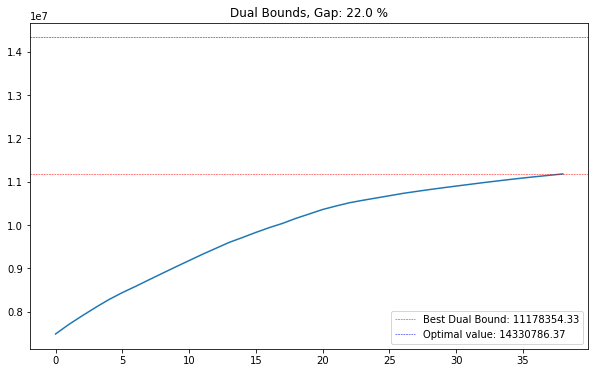

In [11]:
sheet_name = sheet_list[1]
print(sheet_name)
data = read_data(xls, sheet_name=sheet_name)

start = time.time()
Z = Lagrangian_Relaxation_PLRF(data, optimal_values[sheet_name])
end = time.time()

results_LR.append((Z, end-start))

Data-20-24 (1)
Iteration: 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6960 rows, 13650 columns and 24468 nonzeros
Model fingerprint: 0x4b359269
Variable types: 13125 continuous, 525 integer (525 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [3e+01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.283021e+07
Presolve removed 6873 rows and 13553 columns
Presolve time: 0.02s
Presolved: 87 rows, 97 columns, 238 nonzeros
Found heuristic solution: objective 2977679.0000
Variable types: 56 continuous, 41 integer (41 binary)

Root relaxation: objective 2.924927e+06, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objec

Presolve time: 0.01s
Presolved: 3696 rows, 3637 columns, 12658 nonzeros
Variable types: 3189 continuous, 448 integer (448 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      3639709.49 3639709.49  0.00%     -    0s

Explored 1 nodes (8 simplex iterations) in 0.09 seconds (0.07 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 3.63971e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.639709486612e+06, best bound 3.639709486612e+06, gap 0.0000%
Iteration: 7
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model wi

Iteration: 12
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 83520 rows, 163800 columns and 293616 nonzeros
Model fingerprint: 0xefa336b8
Variable types: 157500 continuous, 6300 integer (6300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [3e+01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 4.33577e+06 (0.06s)
Loaded MIP start from previous solve with objective 4.33577e+06

Presolve removed 79737 rows and 160085 columns
Presolve time: 0.03s
Presolved: 3783 rows, 3715 columns, 12968 nonzeros
Variable types: 3267 continuous, 448 integer (448 binary)

Root relaxation: interrupted, 4 iterations, 0.00 seconds (0.00 work units)

 

Loaded MIP start from previous solve with objective 4.74164e+06

Presolve removed 114472 rows and 228275 columns
Presolve time: 0.04s
Presolved: 3848 rows, 3775 columns, 13213 nonzeros
Variable types: 3327 continuous, 448 integer (448 binary)

Root relaxation: interrupted, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      4741640.48 4741347.28  0.01%     -    0s

Explored 1 nodes (5 simplex iterations) in 0.19 seconds (0.15 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 4.74164e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.741640477359e+06, best bound 4.741347282032e+06, gap 0.0062%
Iteration: 18
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [S


Solution count 1: 4.97907e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.979069811022e+06, best bound 4.978622916360e+06, gap 0.0090%
Iteration: 23
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 160080 rows, 313950 columns and 562764 nonzeros
Model fingerprint: 0x26a26de8
Variable types: 301875 continuous, 12075 integer (12075 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [3e+01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 4.99706e+06 (0.11s)
Loaded MIP start from previous solve with objective 4.99706e+06

Presolve removed 156187 rows and 310136 columns
Presolve time: 0.06s
Presolved: 3893 rows, 3814 c

  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 5.06837e+06 (0.12s)
Loaded MIP start from previous solve with objective 5.06837e+06

Presolve removed 190972 rows and 378374 columns
Presolve time: 0.07s
Presolved: 3908 rows, 3826 columns, 13423 nonzeros
Variable types: 3378 continuous, 448 integer (448 binary)

Root relaxation: interrupted, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      5068371.93 5068140.71  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.26 seconds (0.23 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 5.06837e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.068371930183e+06, best bound 5.068140714754e+06, gap 0.0046%
Iteration: 29
Gurobi Op


Explored 1 nodes (5 simplex iterations) in 0.31 seconds (0.26 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 5.11271e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.112712081343e+06, best bound 5.112712081343e+06, gap 0.0000%
Iteration: 34
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 236640 rows, 464100 columns and 831912 nonzeros
Model fingerprint: 0xd2be02bc
Variable types: 446250 continuous, 17850 integer (17850 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [3e+01, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 5.1141e+06 (0.14s)
Loaded MIP start from previous solve wi

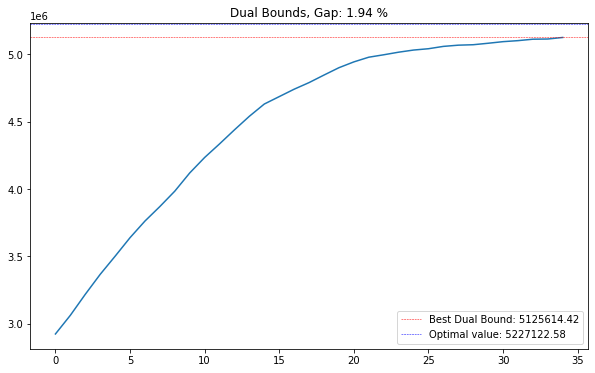

In [12]:
sheet_name = sheet_list[2]
print(sheet_name)
data = read_data(xls, sheet_name=sheet_name)

start = time.time()
Z = Lagrangian_Relaxation_PLRF(data, optimal_values[sheet_name])
end = time.time()

results_LR.append((Z, end-start))

Data-20-24 (2)
Iteration: 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 6960 rows, 13650 columns and 24466 nonzeros
Model fingerprint: 0xd0fafea2
Variable types: 13125 continuous, 525 integer (525 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [4e+01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.608520e+07
Presolve removed 6870 rows and 13559 columns
Presolve time: 0.01s
Presolved: 90 rows, 91 columns, 236 nonzeros
Found heuristic solution: objective 4617714.0000
Variable types: 80 continuous, 11 integer (11 binary)

Root relaxation: objective 3.535102e+06, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objec

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      3999939.45 3999939.45  0.00%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.09 seconds (0.07 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 3.99994e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.999939450540e+06, best bound 3.999939450540e+06, gap 0.0000%
Iteration: 7
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 48720 rows, 95550 columns and 171262 nonzeros
Model fingerprint: 0x29ca7ad5
Variable types: 91875 continuous, 3675 integer (3675 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [4e+01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS ran


Optimize a model with 83520 rows, 163800 columns and 293592 nonzeros
Model fingerprint: 0x59741127
Variable types: 157500 continuous, 6300 integer (6300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [3e+01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 4.45856e+06 (0.07s)
Loaded MIP start from previous solve with objective 4.45856e+06

Presolve removed 79588 rows and 159930 columns
Presolve time: 0.04s
Presolved: 3932 rows, 3870 columns, 13554 nonzeros
Variable types: 3424 continuous, 446 integer (446 binary)

Root relaxation: cutoff, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0      4458563.38 4458563.38  0.00%     -    0s

Explored 1 nodes (6 simplex iterations) in 0.16 secon


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      4784547.22 4784170.80  0.01%     -    0s

Explored 1 nodes (6 simplex iterations) in 0.20 seconds (0.15 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 4.78455e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.784547220726e+06, best bound 4.784170803176e+06, gap 0.0079%
Iteration: 18
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 125280 rows, 245700 columns and 440388 nonzeros
Model fingerprint: 0x094ed4b9
Variable types: 236250 continuous, 9450 integer (9450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 160080 rows, 313950 columns and 562718 nonzeros
Model fingerprint: 0xf3e3b6c2
Variable types: 301875 continuous, 12075 integer (12075 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e+01, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 5.03255e+06 (0.11s)
Loaded MIP start from previous solve with objective 5.03255e+06

Presolve removed 156047 rows and 309997 columns
Presolve time: 0.06s
Presolved: 4033 rows, 3953 columns, 13892 nonzeros
Variable types: 3507 continuous, 446 integer (446 binary)

Root relaxation: interrupted, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      5032548.

Variable types: 3540 continuous, 446 integer (446 binary)

Root relaxation: interrupted, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      5121961.53 5121850.82  0.00%     -    0s

Explored 1 nodes (8 simplex iterations) in 0.27 seconds (0.23 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 5.12196e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.121961532935e+06, best bound 5.121850819419e+06, gap 0.0022%
Iteration: 29
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 201840 rows, 395850 columns and 709514 nonzeros
Model fingerpri

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 236640 rows, 464100 columns and 831844 nonzeros
Model fingerprint: 0x36377f25
Variable types: 446250 continuous, 17850 integer (17850 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e+01, 9e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 5.19123e+06 (0.14s)
Loaded MIP start from previous solve with objective 5.19123e+06

Presolve removed 232548 rows and 460093 columns
Presolve time: 0.09s
Presolved: 4092 rows, 4007 columns, 14109 nonzeros
Variable types: 3561 continuous, 446 integer (446 binary)

Root relaxation: interrupted, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes  

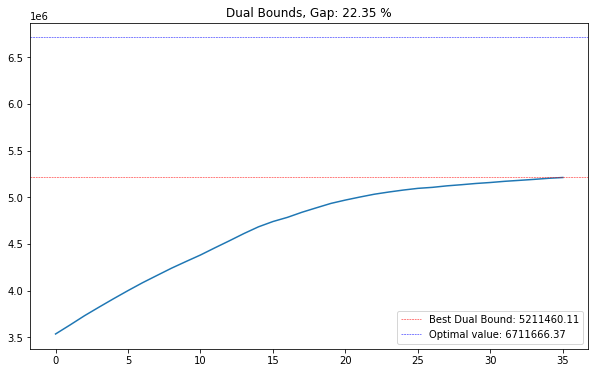

In [13]:
sheet_name = sheet_list[3]
print(sheet_name)
data = read_data(xls, sheet_name=sheet_name)

start = time.time()
Z = Lagrangian_Relaxation_PLRF(data, optimal_values[sheet_name])
end = time.time()

results_LR.append((Z, end-start))

Data-100-24 (1)
Iteration: 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 34800 rows, 65650 columns and 122360 nonzeros
Model fingerprint: 0x437ffeed
Variable types: 63125 continuous, 2525 integer (2525 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 7.120177e+07
Presolve removed 34655 rows and 65498 columns
Presolve time: 0.11s
Presolved: 145 rows, 152 columns, 396 nonzeros
Found heuristic solution: objective 1.943796e+07
Variable types: 83 continuous, 69 integer (69 binary)

Root relaxation: objective 1.938694e+07, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |  


CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 243600 rows, 459550 columns and 856520 nonzeros
Model fingerprint: 0x71b678b7
Variable types: 441875 continuous, 17675 integer (17675 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 2.08203e+07 (0.23s)
Loaded MIP start from previous solve with objective 2.08203e+07

Presolve removed 224125 rows and 440358 columns
Presolve time: 0.09s
Presolved: 19475 rows, 19192 columns, 67099 nonzeros
Variable types: 16932 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  


Presolve removed 397832 rows and 768362 columns
Presolve time: 0.16s
Presolved: 19768 rows, 19438 columns, 68087 nonzeros
Variable types: 17178 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      2.1824e+07 2.1822e+07  0.01%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.70 seconds (0.66 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 2.18238e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.182382669141e+07, best bound 2.182196163618e+07, gap 0.0085%
Iteration: 13
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 log

Model fingerprint: 0x0bc4a4e9
Variable types: 1136250 continuous, 45450 integer (45450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [6e+00, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 2.30413e+07 (0.51s)
Loaded MIP start from previous solve with objective 2.30413e+07

Presolve removed 606413 rows and 1162068 columns
Presolve time: 0.22s
Presolved: 19987 rows, 19632 columns, 68879 nonzeros
Variable types: 17372 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      2.3041e+07 2.3039e+07  0.01%     -    0s

Explored 1 nodes (3 simplex iterations) in 1.03 seconds (0.90 work units)
Thread count was 16 (of 16 availab

Variable types: 1515000 continuous, 60600 integer (60600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [5e+00, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 2.38625e+07 (0.55s)
Loaded MIP start from previous solve with objective 2.38625e+07

Presolve removed 814970 rows and 1555755 columns
Presolve time: 0.30s
Presolved: 20230 rows, 19845 columns, 69745 nonzeros
Variable types: 17585 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 1.22 seconds (1.15 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 2.38625e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.386247810730e+07, best bound 2.386016359546e+07, gap 0.0097%
Iteration: 25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (

Variable types: 17696 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 1.42 seconds (1.40 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 2.43197e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.431970322872e+07, best bound 2.431738862386e+07, gap 0.0095%
Iteration: 31
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1078800 rows, 2035150 columns and 3793160 nonzeros
Model fingerprint: 0x500f7ef1
Variable types: 1956875 continuous, 78275 integer (78275 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [5e+00, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range    

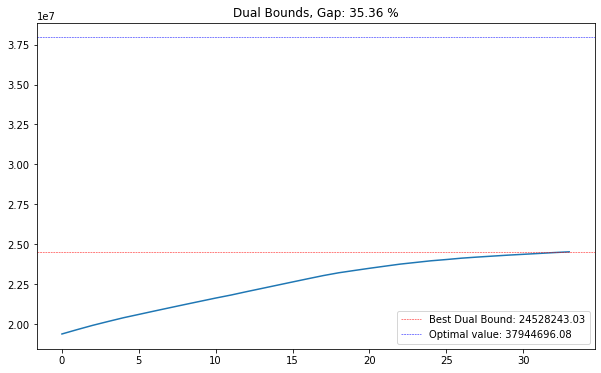

In [14]:
sheet_name = sheet_list[4]
print(sheet_name)
data = read_data(xls, sheet_name=sheet_name)

start = time.time()
Z = Lagrangian_Relaxation_PLRF(data, optimal_values[sheet_name])
end = time.time()

results_LR.append((Z, end-start))

Data-100-24 (2)
Iteration: 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 34800 rows, 65650 columns and 122360 nonzeros
Model fingerprint: 0x437ffeed
Variable types: 63125 continuous, 2525 integer (2525 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 7.120177e+07
Presolve removed 34655 rows and 65498 columns
Presolve time: 0.11s
Presolved: 145 rows, 152 columns, 396 nonzeros
Found heuristic solution: objective 1.943796e+07
Variable types: 83 continuous, 69 integer (69 binary)

Root relaxation: objective 1.938694e+07, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |  


CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 243600 rows, 459550 columns and 856520 nonzeros
Model fingerprint: 0x71b678b7
Variable types: 441875 continuous, 17675 integer (17675 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 2.08203e+07 (0.24s)
Loaded MIP start from previous solve with objective 2.08203e+07

Presolve removed 224125 rows and 440358 columns
Presolve time: 0.10s
Presolved: 19475 rows, 19192 columns, 67099 nonzeros
Variable types: 16932 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  


Presolve removed 397832 rows and 768362 columns
Presolve time: 0.15s
Presolved: 19768 rows, 19438 columns, 68087 nonzeros
Variable types: 17178 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      2.1824e+07 2.1822e+07  0.01%     -    0s

Explored 1 nodes (4 simplex iterations) in 0.69 seconds (0.66 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 2.18238e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.182382669141e+07, best bound 2.182196163618e+07, gap 0.0085%
Iteration: 13
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 log

Model fingerprint: 0x0bc4a4e9
Variable types: 1136250 continuous, 45450 integer (45450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [6e+00, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 2.30413e+07 (0.41s)
Loaded MIP start from previous solve with objective 2.30413e+07

Presolve removed 606413 rows and 1162068 columns
Presolve time: 0.24s
Presolved: 19987 rows, 19632 columns, 68879 nonzeros
Variable types: 17372 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      2.3041e+07 2.3039e+07  0.01%     -    0s

Explored 1 nodes (3 simplex iterations) in 0.95 seconds (0.90 work units)
Thread count was 16 (of 16 availab

Variable types: 1515000 continuous, 60600 integer (60600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [5e+00, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 2.38625e+07 (0.63s)
Loaded MIP start from previous solve with objective 2.38625e+07

Presolve removed 814970 rows and 1555755 columns
Presolve time: 0.35s
Presolved: 20230 rows, 19845 columns, 69745 nonzeros
Variable types: 17585 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 1.39 seconds (1.15 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 2.38625e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.386247810730e+07, best bound 2.386016359546e+07, gap 0.0097%
Iteration: 25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (

Variable types: 17696 continuous, 2260 integer (2260 binary)

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 1.50 seconds (1.40 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 2.43197e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.431970322872e+07, best bound 2.431738862386e+07, gap 0.0095%
Iteration: 31
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1078800 rows, 2035150 columns and 3793160 nonzeros
Model fingerprint: 0x500f7ef1
Variable types: 1956875 continuous, 78275 integer (78275 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [5e+00, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range    

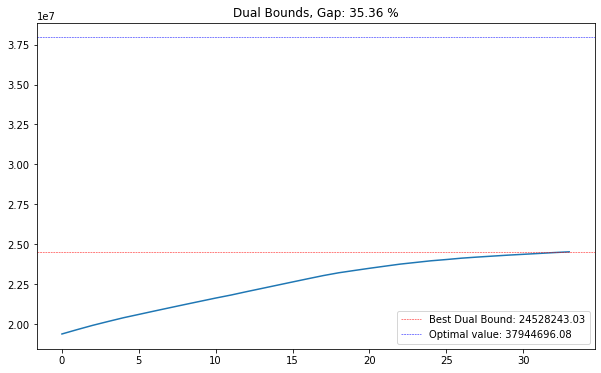

In [15]:
sheet_name = sheet_list[5]
print(sheet_name)
data = read_data(xls, sheet_name=sheet_name)

start = time.time()
Z = Lagrangian_Relaxation_PLRF(data, optimal_values[sheet_name])
end = time.time()

results_LR.append((Z, end-start))

Data-200-24
Iteration: 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 69600 rows, 130650 columns and 244720 nonzeros
Model fingerprint: 0x6d726050
Variable types: 125625 continuous, 5025 integer (5025 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.384981e+08
Presolve removed 56072 rows and 115366 columns
Presolve time: 0.08s
Presolved: 13528 rows, 15284 columns, 35842 nonzeros
Found heuristic solution: objective 5.668860e+07
Variable types: 10928 continuous, 4356 integer (4266 binary)
Found heuristic solution: objective 3.889738e+07

Root relaxation: objective 3.877388e+07, 4 iterations, 0.00 sec

Iteration: 7
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 487200 rows, 914550 columns and 1713040 nonzeros
Model fingerprint: 0xfa2cd481
Variable types: 879375 continuous, 35175 integer (35175 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+01, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 4.16407e+07 (0.47s)
Loaded MIP start from previous solve with objective 4.16407e+07

Presolve removed 448250 rows and 876166 columns
Presolve time: 0.19s
Presolved: 38950 rows, 38384 columns, 134198 nonzeros
Variable types: 33864 continuous, 4520 integer (4520 binary)

Root relaxation: interrupted, 2 iterations, 0.00 seconds (0.00 work

Loaded MIP start from previous solve with objective 4.36477e+07

Presolve removed 795664 rows and 1528924 columns
Presolve time: 0.35s
Presolved: 39536 rows, 38876 columns, 136174 nonzeros
Variable types: 34356 continuous, 4520 integer (4520 binary)

Root relaxation: interrupted, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      4.3648e+07 4.3643e+07  0.01%     -    1s

Explored 1 nodes (2 simplex iterations) in 1.46 seconds (1.43 work units)
Thread count was 16 (of 16 available processors)

Solution count 1: 4.36477e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.364765338282e+07, best bound 4.364338151740e+07, gap 0.0098%
Iteration: 13
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction


Optimize a model with 1252800 rows, 2351700 columns and 4404960 nonzeros
Model fingerprint: 0x542667ba
Variable types: 2261250 continuous, 90450 integer (90450 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [6e+00, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 4.60826e+07 (0.95s)
Loaded MIP start from previous solve with objective 4.60826e+07
Processed MIP start in 1.06 seconds (0.90 work units)

Presolve removed 1212826 rows and 2312436 columns
Presolve time: 0.47s
Presolved: 39974 rows, 39264 columns, 137758 nonzeros
Variable types: 34744 continuous, 4520 integer (4520 binary)

Root relaxation: interrupted, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0      4.6083e+07 4.6079e+0

Iteration: 24
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1670400 rows, 3135600 columns and 5873280 nonzeros
Model fingerprint: 0xe6bdd7f0
Variable types: 3015000 continuous, 120600 integer (120600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [5e+00, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 4.7725e+07 (1.14s)
Loaded MIP start from previous solve with objective 4.7725e+07
Processed MIP start in 1.26 seconds (1.13 work units)

Presolve removed 1629940 rows and 3095910 columns
Presolve time: 0.61s
Presolved: 40460 rows, 39690 columns, 139490 nonzeros
Variable types: 35170 continuous, 4520 integer (4520 binary)

Root re

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2088000 rows, 3919500 columns and 7341600 nonzeros
Model fingerprint: 0xfeaa4f70
Variable types: 3768750 continuous, 150750 integer (150750 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [5e+00, 8e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

MIP start from previous solve produced solution with objective 4.86394e+07 (1.32s)
Loaded MIP start from previous solve with objective 4.86394e+07
Processed MIP start in 1.49 seconds (1.36 work units)

Presolve removed 2047284 rows and 3879588 columns
Presolve time: 0.76s
Presolved: 40716 rows, 39912 columns, 140402 nonzeros
Variable types: 35392 continuous, 4520 integer (4520 binary)

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 2.87 seconds (2.98 work units)
Thread count was 16 (of 16 available processors)

S

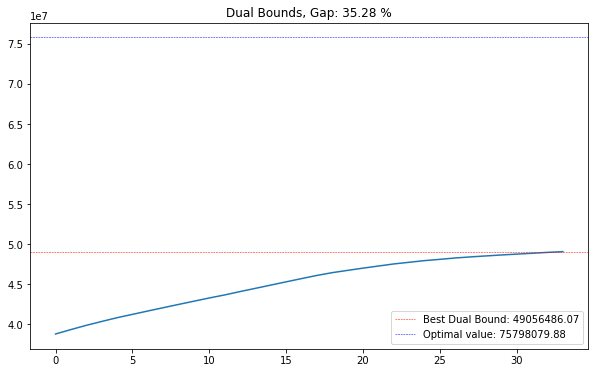

In [16]:
sheet_name = sheet_list[6]
print(sheet_name)
data = read_data(xls, sheet_name=sheet_name)

start = time.time()
Z = Lagrangian_Relaxation_PLRF(data, optimal_values[sheet_name])
end = time.time()

results_LR.append((Z, end-start))

In [19]:
print(results_LR)

[(85839.08850058631, 10.781669616699219), (11178354.328293849, 7.170841693878174), (5125614.4162301775, 21.626482486724854), (5211460.110143085, 22.371801614761353), (24528243.032682203, 102.2843930721283), (24528243.032682203, 103.09551882743835), (49056486.065364346, 207.29092359542847)]
